# GDN

In [3]:
import numpy as np
import torch, os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

## SMAP dataset preparation

### Data import

In [ ]:
# --- 1. Configuration and File Paths ---
# Define the base directory where the SMAP data is located
BASE_DIR = './data' 
TRAIN_DATA_PATH = BASE_DIR + '/SMAP/SMAP/SMAP_train.npy'
TEST_DATA_PATH = BASE_DIR + '/SMAP/SMAP/SMAP_test.npy'
TEST_LABEL_PATH = BASE_DIR + '/SMAP/SMAP/SMAP_test_label.npy'

# --- 2. Data Loading and Shape Inspection ---
print("--- Loading Raw Data ---")
try:
    X_train_raw = np.load(TRAIN_DATA_PATH)
    X_test_raw = np.load(TEST_DATA_PATH)
    y_test_raw = np.load(TEST_LABEL_PATH)
except FileNotFoundError as e:
    print(f"Error: {e}. Download the dataset and place it in the specified directory.")
    from torch_timeseries.dataset import SMAP
    SMAP(root=BASE_DIR)
    print("Dataset downloaded.")
    X_train_raw = np.load(TRAIN_DATA_PATH)
    X_test_raw = np.load(TEST_DATA_PATH)
    y_test_raw = np.load(TEST_LABEL_PATH)
print("Data Loaded Successfully.")
T_train, D_features = X_train_raw.shape
T_test, _ = X_test_raw.shape

--- Loading Raw Data ---
Error: [Errno 2] No such file or directory: './data/SMAP/SMAP_train.npy'. Download the dataset and place it in the specified directory.


100%|██████████| 1656330/1656330 [00:00<00:00, 17262233.99it/s]


Extracting ./data/SMAP/SMAP.zip to ./data/SMAP
Dataset downloaded.


FileNotFoundError: [Errno 2] No such file or directory: './data/SMAP/SMAP_train.npy'

### Vizualization
Plotting sensor n°0,1,2,4 and 5.

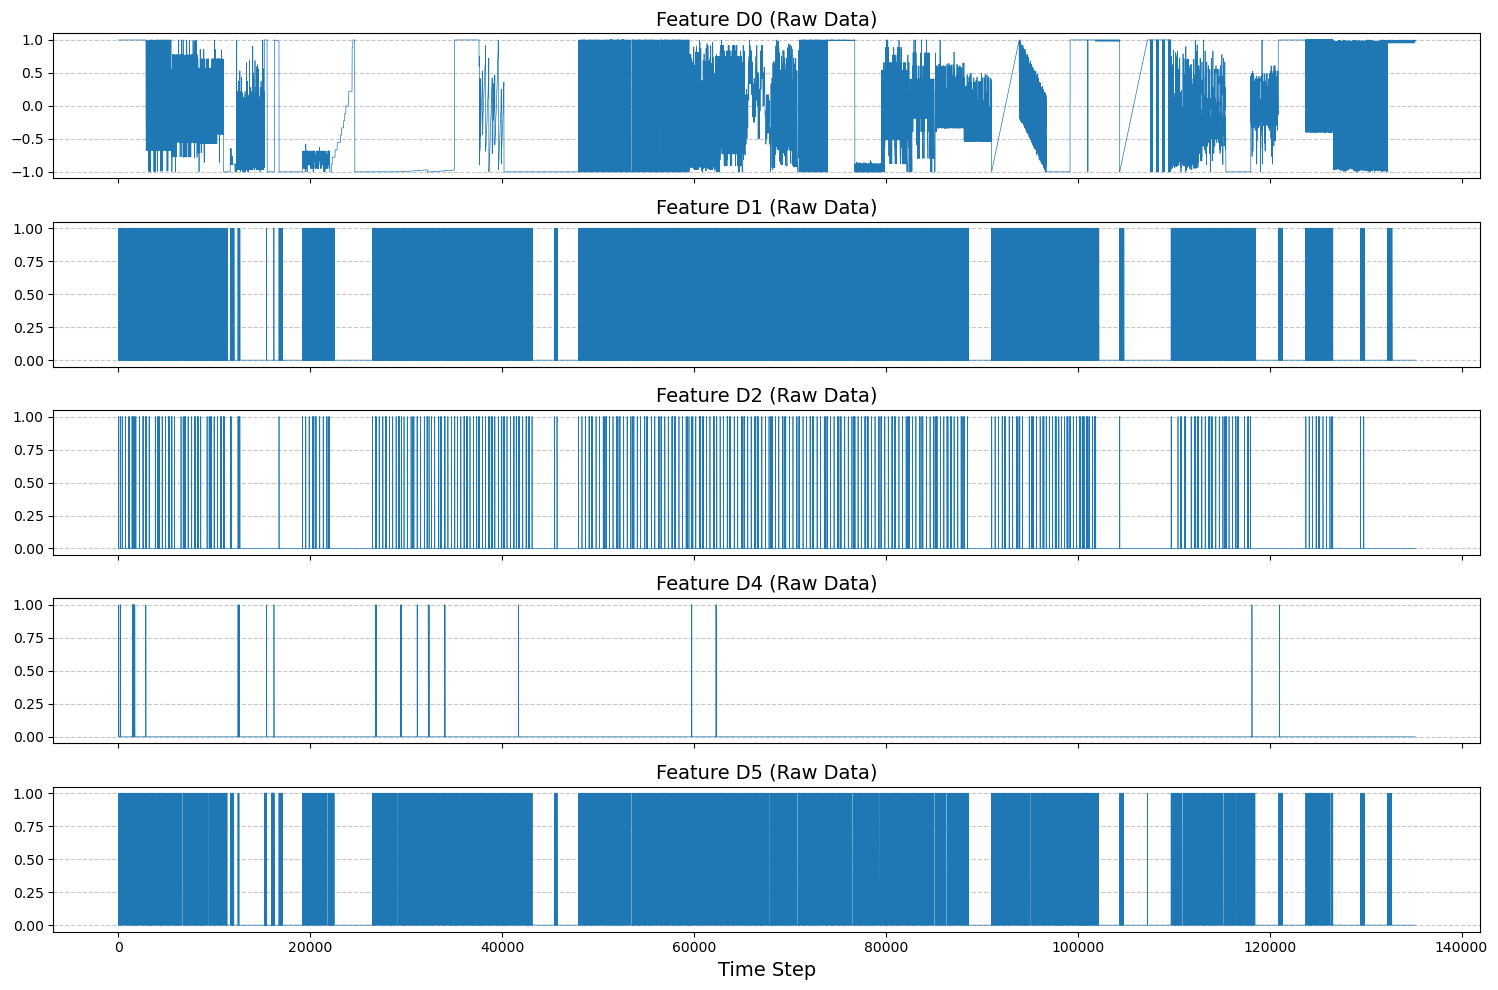

In [4]:
feature_indices = [0,1,2,4,5] 
features_to_plot = X_train_raw[:, feature_indices]
time_index = np.arange(T_train)

fig, axes = plt.subplots(5, 1, figsize=(15, 10), sharex=True)
axes = axes.flatten()
for i, feature_index in enumerate(feature_indices):
    ax = axes[i] 
    ax.plot(
        time_index, 
        features_to_plot[:, i], 
        label=f'Feature D{feature_index}', 
        linewidth=0.5
    )
    # Set title, labels, and grid
    ax.set_title(f'Feature D{feature_index} (Raw Data)', fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

axes[4].set_xlabel('Time Step', fontsize=14)
plt.tight_layout()
plt.show()

Plotting the anomaly occurences

/var/folders/lc/6tn5hzlx0tqgcqc8_wc19qn40000gp/T/ipykernel_8045/2102559636.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right', fontsize=12)


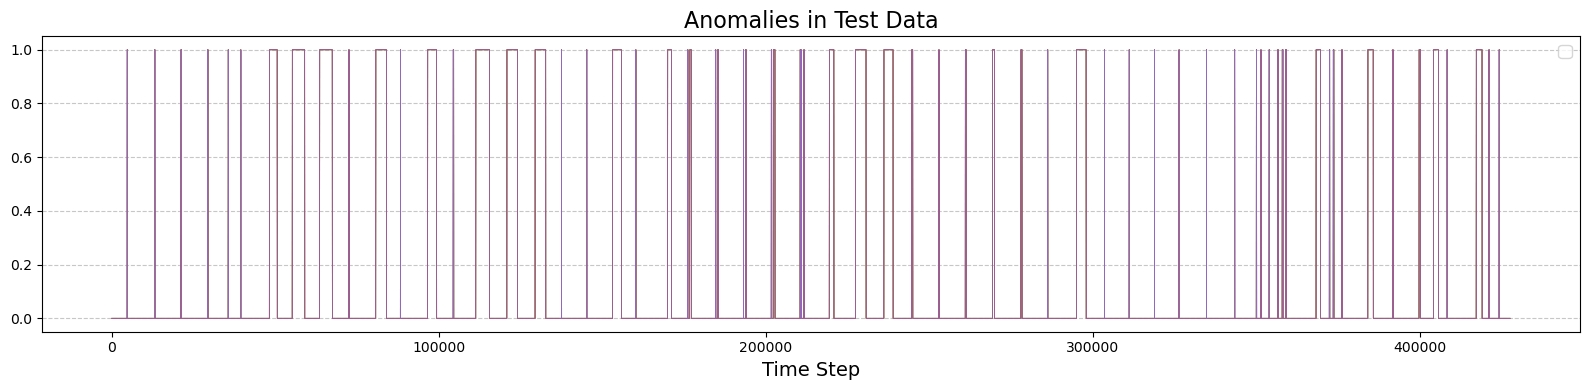

In [5]:
plt.figure(figsize=(16, 4))
time_index = np.arange(T_test)
# Iterate through the selected features and plot them
for i, feature_index in enumerate(feature_indices):
    plt.plot(
        time_index, 
        y_test_raw,
        linewidth=0.5
    )

plt.title(f'Anomalies in Test Data', fontsize=16)
plt.xlabel('Time Step', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Basic statistics

In [6]:
# --- Data Integrity Checks ---
def check_nan_inf(data, name):
    if np.isnan(data).any():
        print(f"Warning: {name} contains NaN values.")
    if np.isinf(data).any():
        print(f"Warning: {name} contains Inf values.")
    if not np.isnan(data).any() and not np.isinf(data).any():
        print(f"{name} contains no NaN or Inf values.")

# --- Basic Statistics ---

def basic_statistics(data):
    print(f"Length : {data.shape[0]}")
    print(f"Num of sensors (features): {data.shape[1]}")
    unique_val = {}
    repartition = [0,0]
    nb_continous = 0
    nb_discrete = 0
    for i in range(data.shape[1]):
        unique_vals, count = np.unique(data[:, i], return_counts=True)
        n_unique = len(unique_vals)
        if n_unique <= 2:
            for i in range(n_unique):
                if unique_vals[i] == 0:
                    repartition[0] += count[i]
                else:
                    repartition[1] += count[i]
            nb_discrete += 1
            str_unique = ', '.join(map(str, unique_vals))
            in_unique = False
            for k in unique_val.keys():
                if k == str_unique:
                    unique_val[k] += 1
                    in_unique = True
                    break
            if not in_unique:
                unique_val[str_unique] = 1 
        else:
            nb_continous += 1
    print(f"Number of continuous features: {nb_continous}")
    print(f"Number of discrete features: {nb_discrete}")
    print("Discrete feature value distributions:")
    for k, v in unique_val.items():
        print(f"    Values: [{k}] -> Count: {v} feature(s)")
    print(f"    Repartition of discrete feature values: "
          f"value 0 : {repartition[0]} ({100*repartition[0]/(repartition[0]+repartition[1]):.2f} %), " 
          f"value 1 : {repartition[1]} ({100*repartition[1]/(repartition[0]+repartition[1]):.2f} %)")

def stat_labels(labels):
    n_anomalies = np.sum(labels)
    n_normal = labels.shape[0] - n_anomalies
    print(f"Total number of points: {labels.shape[0]}")
    print(f"Number of normal points: {n_normal} ({100*n_normal/labels.shape[0]:.2f} %)")
    print(f"Number of anomalous points: {n_anomalies} ({100*n_anomalies/labels.shape[0]:.2f} %)")
    ongoing = 0
    nb_anomaly_sequences = 0
    nb_isolated_anomalies = 0
    length_anomaly_sequences = []
    for l in labels:
        if l == 1:
            ongoing += 1
        if l == 0:
            if ongoing > 1:
                nb_anomaly_sequences += 1
                length_anomaly_sequences.append(ongoing)
                ongoing = 0
            elif ongoing == 1:
                nb_isolated_anomalies += 1
                ongoing = 0
    if ongoing > 1:
        nb_anomaly_sequences += 1
    elif ongoing == 1:
        nb_isolated_anomalies += 1
    length_anomaly_sequences = np.array(length_anomaly_sequences)
    print(f"Number of isolated anomalies (length = 1): {nb_isolated_anomalies}")
    print(f"Number of anomaly sequences (length > 1): {nb_anomaly_sequences}")
    if length_anomaly_sequences.size > 0:
        print(f"    Anomaly sequence lengths -- Min: {np.min(length_anomaly_sequences)}, "
              f"    Max: {np.max(length_anomaly_sequences)}, "
              f"    Mean: {np.mean(length_anomaly_sequences):.2f}, "
              f"    Median: {np.median(length_anomaly_sequences)}")

In [7]:
check_nan_inf(X_train_raw, "X_train_raw")
check_nan_inf(X_test_raw, "X_test_raw")
check_nan_inf(y_test_raw, "y_test_raw")

print("\n--- Basic Statistics for X_train_raw ---")
basic_statistics(X_train_raw)

print("\n--- Basic Statistics for X_test_raw ---")
basic_statistics(X_test_raw)

print("\n--- Basic Statistics for y_test_raw ---")
stat_labels(y_test_raw)

X_train_raw contains no NaN or Inf values.
X_test_raw contains no NaN or Inf values.
y_test_raw contains no NaN or Inf values.

--- Basic Statistics for X_train_raw ---
Length : 135183
Num of sensors (features): 25
Number of continuous features: 1
Number of discrete features: 24
Discrete feature value distributions:
    Values: [0.0, 1.0] -> Count: 23 feature(s)
    Values: [0.0] -> Count: 1 feature(s)
    Repartition of discrete feature values: value 0 : 3191110 (98.36 %), value 1 : 53282 (1.64 %)

--- Basic Statistics for X_test_raw ---
Length : 427617
Num of sensors (features): 25
Number of continuous features: 1
Number of discrete features: 24
Discrete feature value distributions:
    Values: [0.0, 1.0] -> Count: 24 feature(s)
    Repartition of discrete feature values: value 0 : 10144228 (98.84 %), value 1 : 118580 (1.16 %)

--- Basic Statistics for y_test_raw ---
Total number of points: 427617
Number of normal points: 372921 (87.21 %)
Number of anomalous points: 54696 (12.79 %)
N

### Build dataloader for GDN model
We need sliding windows

In [8]:
# Model parameters
WINDOW_SIZE = 30
PREDICTION_HORIZON = 1
BATCH_SIZE = 64

In [9]:
def create_sliding_windows(data, window_size):
    """
    Creates overlapping sequences (sliding windows) from the time series data.
    Input: (T, D) -> Output: (N_samples, Window_Size, D)
    """
    N_time, N_dims = data.shape
    windows = []
    # Loop from 0 up to the point where a full window can be created
    for i in range(N_time - window_size):
        windows.append(data[i : i + window_size, :])
    return np.array(windows)

# Create windows for training data (X_train) and testing data (X_test)
X_train_windows = create_sliding_windows(X_train_raw, WINDOW_SIZE)
X_test_windows = create_sliding_windows(X_test_raw, WINDOW_SIZE)

# For anomaly detection, the GDN model needs to predict the *next* time step (t+1).
# The target y is the time step *after* the window: data[i + window_size, :]
# The anomaly detection target y_test_label is for the predicted point (t+1).
y_train_windows = X_train_raw[WINDOW_SIZE:, :]  # Target is the next point
y_test_windows = X_test_raw[WINDOW_SIZE:, :]
y_test_labels_windows = y_test_raw[WINDOW_SIZE:] # Anomaly label for the predicted point

print(f"\nX_train_windows shape: {X_train_windows.shape}") 
print(f"y_train_windows shape: {y_train_windows.shape}")
print(f"X_test_windows shape: {X_test_windows.shape}")
print(f"y_test_windows shape: {y_test_windows.shape}")
print(f"y_test_labels_windows shape: {y_test_labels_windows.shape}")

# --- 5. PyTorch DataLoader Creation ---
import numpy as np # <-- ADD THIS LINE
X_train_tensor = torch.from_numpy(X_train_windows)
y_train_tensor = torch.from_numpy(y_train_windows)

X_test_tensor = torch.from_numpy(X_test_windows)
y_test_tensor = torch.from_numpy(y_test_windows)
y_test_labels_tensor = torch.from_numpy(y_test_labels_windows)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor, y_test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("\n--- DataLoader Creation Complete ---")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of testing batches: {len(test_loader)}")
print("Data is ready for the GDN model training.")


X_train_windows shape: (135153, 30, 25)
y_train_windows shape: (135153, 25)
X_test_windows shape: (427587, 30, 25)
y_test_windows shape: (427587, 25)
y_test_labels_windows shape: (427587,)

--- DataLoader Creation Complete ---
Number of training batches: 2112
Number of testing batches: 6682
Data is ready for the GDN model training.


## Model code from the paper


In [11]:
import torch
from torch.nn import Parameter, Linear, Sequential, BatchNorm1d, ReLU
import torch.nn.functional as F
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

from torch_geometric.nn.inits import glorot, zeros
import time
import math

class GraphLayer(MessagePassing):
    def __init__(self, in_channels, out_channels, heads=1, concat=True,
                 negative_slope=0.2, dropout=0, bias=True, inter_dim=-1,**kwargs):
        super(GraphLayer, self).__init__(aggr='add', **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.concat = concat
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.__alpha__ = None

        self.lin = Linear(in_channels, heads * out_channels, bias=False)

        self.att_i = Parameter(torch.Tensor(1, heads, out_channels))
        self.att_j = Parameter(torch.Tensor(1, heads, out_channels))
        self.att_em_i = Parameter(torch.Tensor(1, heads, out_channels))
        self.att_em_j = Parameter(torch.Tensor(1, heads, out_channels))

        if bias and concat:
            self.bias = Parameter(torch.Tensor(heads * out_channels))
        elif bias and not concat:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.lin.weight)
        glorot(self.att_i)
        glorot(self.att_j)
        
        zeros(self.att_em_i)
        zeros(self.att_em_j)

        zeros(self.bias)



    def forward(self, x, edge_index, embedding, return_attention_weights=False):
        """"""
        if torch.is_tensor(x):
            x = self.lin(x)
            x = (x, x)
        else:
            x = (self.lin(x[0]), self.lin(x[1]))

        edge_index, _ = remove_self_loops(edge_index)
        edge_index, _ = add_self_loops(edge_index,
                                       num_nodes=x[1].size(self.node_dim))

        out = self.propagate(edge_index, x=x, embedding=embedding, edges=edge_index,
                             return_attention_weights=return_attention_weights)

        if self.concat:
            out = out.view(-1, self.heads * self.out_channels)
        else:
            out = out.mean(dim=1)

        if self.bias is not None:
            out = out + self.bias

        if return_attention_weights:
            alpha, self.__alpha__ = self.__alpha__, None
            return out, (edge_index, alpha)
        else:
            return out

    def message(self, x_i, x_j, edge_index_i, size_i,
                embedding,
                edges,
                return_attention_weights):

        x_i = x_i.view(-1, self.heads, self.out_channels)
        x_j = x_j.view(-1, self.heads, self.out_channels)

        if embedding is not None:
            embedding_i, embedding_j = embedding[edge_index_i], embedding[edges[0]]
            embedding_i = embedding_i.unsqueeze(1).repeat(1,self.heads,1)
            embedding_j = embedding_j.unsqueeze(1).repeat(1,self.heads,1)

            key_i = torch.cat((x_i, embedding_i), dim=-1)
            key_j = torch.cat((x_j, embedding_j), dim=-1)



        cat_att_i = torch.cat((self.att_i, self.att_em_i), dim=-1)
        cat_att_j = torch.cat((self.att_j, self.att_em_j), dim=-1)

        alpha = (key_i * cat_att_i).sum(-1) + (key_j * cat_att_j).sum(-1)


        alpha = alpha.view(-1, self.heads, 1)


        alpha = F.leaky_relu(alpha, self.negative_slope)
        alpha = softmax(alpha, edge_index_i, size_i)

        if return_attention_weights:
            self.__alpha__ = alpha

        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        
        return x_j * alpha.view(-1, self.heads, 1)



    def __repr__(self):
        return '{}({}, {}, heads={})'.format(self.__class__.__name__,
                                             self.in_channels,
                                             self.out_channels, self.heads)


In [12]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import time
from util.time import *
from util.env import *
from torch_geometric.nn import GCNConv, GATConv, EdgeConv
import math
import torch.nn.functional as F


def get_batch_edge_index(org_edge_index, batch_num, node_num):
    # org_edge_index:(2, edge_num)
    edge_index = org_edge_index.clone().detach()
    edge_num = org_edge_index.shape[1]
    batch_edge_index = edge_index.repeat(1,batch_num).contiguous()

    for i in range(batch_num):
        batch_edge_index[:, i*edge_num:(i+1)*edge_num] += i*node_num

    return batch_edge_index.long()


class OutLayer(nn.Module):
    def __init__(self, in_num, node_num, layer_num, inter_num = 512):
        super(OutLayer, self).__init__()

        modules = []

        for i in range(layer_num):
            # last layer, output shape:1
            if i == layer_num-1:
                modules.append(nn.Linear( in_num if layer_num == 1 else inter_num, 1))
            else:
                layer_in_num = in_num if i == 0 else inter_num
                modules.append(nn.Linear( layer_in_num, inter_num ))
                modules.append(nn.BatchNorm1d(inter_num))
                modules.append(nn.ReLU())

        self.mlp = nn.ModuleList(modules)

    def forward(self, x):
        out = x

        for mod in self.mlp:
            if isinstance(mod, nn.BatchNorm1d):
                out = out.permute(0,2,1)
                out = mod(out)
                out = out.permute(0,2,1)
            else:
                out = mod(out)

        return out



class GNNLayer(nn.Module):
    def __init__(self, in_channel, out_channel, inter_dim=0, heads=1, node_num=100):
        super(GNNLayer, self).__init__()


        self.gnn = GraphLayer(in_channel, out_channel, inter_dim=inter_dim, heads=heads, concat=False)

        self.bn = nn.BatchNorm1d(out_channel)
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x, edge_index, embedding=None, node_num=0):

        out, (new_edge_index, att_weight) = self.gnn(x, edge_index, embedding, return_attention_weights=True)
        self.att_weight_1 = att_weight
        self.edge_index_1 = new_edge_index
  
        out = self.bn(out)
        
        return self.relu(out)


class GDN(nn.Module):
    def __init__(self, edge_index_sets, node_num, dim=64, out_layer_inter_dim=256, input_dim=10, out_layer_num=1, topk=20):

        super(GDN, self).__init__()

        self.edge_index_sets = edge_index_sets

        device = get_device()

        edge_index = edge_index_sets[0]


        embed_dim = dim
        self.embedding = nn.Embedding(node_num, embed_dim)
        self.bn_outlayer_in = nn.BatchNorm1d(embed_dim)


        edge_set_num = len(edge_index_sets)
        self.gnn_layers = nn.ModuleList([
            GNNLayer(input_dim, dim, inter_dim=dim+embed_dim, heads=1) for i in range(edge_set_num)
        ])


        self.node_embedding = None
        self.topk = topk
        self.learned_graph = None

        self.out_layer = OutLayer(dim*edge_set_num, node_num, out_layer_num, inter_num = out_layer_inter_dim)

        self.cache_edge_index_sets = [None] * edge_set_num
        self.cache_embed_index = None

        self.dp = nn.Dropout(0.2)

        self.init_params()
    
    def init_params(self):
        nn.init.kaiming_uniform_(self.embedding.weight, a=math.sqrt(5))


    def forward(self, data, org_edge_index):

        x = data.clone().detach()
        edge_index_sets = self.edge_index_sets

        device = data.device

        batch_num, node_num, all_feature = x.shape
        x = x.view(-1, all_feature).contiguous()


        gcn_outs = []
        for i, edge_index in enumerate(edge_index_sets):
            edge_num = edge_index.shape[1]
            cache_edge_index = self.cache_edge_index_sets[i]

            if cache_edge_index is None or cache_edge_index.shape[1] != edge_num*batch_num:
                self.cache_edge_index_sets[i] = get_batch_edge_index(edge_index, batch_num, node_num).to(device)
            
            batch_edge_index = self.cache_edge_index_sets[i]
            
            all_embeddings = self.embedding(torch.arange(node_num).to(device))

            weights_arr = all_embeddings.detach().clone()
            all_embeddings = all_embeddings.repeat(batch_num, 1)

            weights = weights_arr.view(node_num, -1)

            cos_ji_mat = torch.matmul(weights, weights.T)
            normed_mat = torch.matmul(weights.norm(dim=-1).view(-1,1), weights.norm(dim=-1).view(1,-1))
            cos_ji_mat = cos_ji_mat / normed_mat

            dim = weights.shape[-1]
            topk_num = self.topk

            topk_indices_ji = torch.topk(cos_ji_mat, topk_num, dim=-1)[1]

            self.learned_graph = topk_indices_ji

            gated_i = torch.arange(0, node_num).T.unsqueeze(1).repeat(1, topk_num).flatten().to(device).unsqueeze(0)
            gated_j = topk_indices_ji.flatten().unsqueeze(0)
            gated_edge_index = torch.cat((gated_j, gated_i), dim=0)

            batch_gated_edge_index = get_batch_edge_index(gated_edge_index, batch_num, node_num).to(device)
            gcn_out = self.gnn_layers[i](x, batch_gated_edge_index, node_num=node_num*batch_num, embedding=all_embeddings)

            
            gcn_outs.append(gcn_out)

        x = torch.cat(gcn_outs, dim=1)
        x = x.view(batch_num, node_num, -1)


        indexes = torch.arange(0,node_num).to(device)
        out = torch.mul(x, self.embedding(indexes))
        
        out = out.permute(0,2,1)
        out = F.relu(self.bn_outlayer_in(out))
        out = out.permute(0,2,1)

        out = self.dp(out)
        out = self.out_layer(out)
        out = out.view(-1, node_num)
   

        return out
        

## Graph construction code from the paper

In [13]:
# preprocess data
import numpy as np
import re


def get_most_common_features(target, all_features, max = 3, min = 3):
    res = []
    main_keys = target.split('_')

    for feature in all_features:
        if target == feature:
            continue

        f_keys = feature.split('_')
        common_key_num = len(list(set(f_keys) & set(main_keys)))

        if common_key_num >= min and common_key_num <= max:
            res.append(feature)

    return res

def build_net(target, all_features):
    # get edge_indexes, and index_feature_map
    main_keys = target.split('_')
    edge_indexes = [
        [],
        []
    ]
    index_feature_map = [target]

    # find closest features(nodes):
    parent_list = [target]
    graph_map = {}
    depth = 2
    
    for i in range(depth):        
        for feature in parent_list:
            children = get_most_common_features(feature, all_features)

            if feature not in graph_map:
                graph_map[feature] = []
            
            # exclude parent
            pure_children = []
            for child in children:
                if child not in graph_map:
                    pure_children.append(child)

            graph_map[feature] = pure_children

            if feature not in index_feature_map:
                index_feature_map.append(feature)
            p_index = index_feature_map.index(feature)
            for child in pure_children:
                if child not in index_feature_map:
                    index_feature_map.append(child)
                c_index = index_feature_map.index(child)

                edge_indexes[1].append(p_index)
                edge_indexes[0].append(c_index)

        parent_list = pure_children

    return edge_indexes, index_feature_map


def construct_data(data, feature_map, labels=0):
    res = []

    for feature in feature_map:
        if feature in data.columns:
            res.append(data.loc[:, feature].values.tolist())
        else:
            print(feature, 'not exist in data')
    # append labels as last
    sample_n = len(res[0])

    if type(labels) == int:
        res.append([labels]*sample_n)
    elif len(labels) == sample_n:
        res.append(labels)

    return res

def build_loc_net(struc, all_features, feature_map=[]):

    index_feature_map = feature_map
    edge_indexes = [
        [],
        []
    ]
    for node_name, node_list in struc.items():
        if node_name not in all_features:
            continue

        if node_name not in index_feature_map:
            index_feature_map.append(node_name)
        
        p_index = index_feature_map.index(node_name)
        for child in node_list:
            if child not in all_features:
                continue

            if child not in index_feature_map:
                print(f'error: {child} not in index_feature_map')
                # index_feature_map.append(child)

            c_index = index_feature_map.index(child)
            # edge_indexes[0].append(p_index)
            # edge_indexes[1].append(c_index)
            edge_indexes[0].append(c_index)
            edge_indexes[1].append(p_index)
        

    
    return edge_indexes

In [14]:
import glob


def get_feature_map(dataset):
    feature_file = open(f'./data/{dataset}/list.txt', 'r')
    feature_list = []
    for ft in feature_file:
        feature_list.append(ft.strip())

    return feature_list
# graph is 'fully-connect'
def get_fc_graph_struc(dataset):
    feature_file = open(f'./data/{dataset}/list.txt', 'r')

    struc_map = {}
    feature_list = []
    for ft in feature_file:
        feature_list.append(ft.strip())

    for ft in feature_list:
        if ft not in struc_map:
            struc_map[ft] = []

        for other_ft in feature_list:
            if other_ft is not ft:
                struc_map[ft].append(other_ft)
    
    return struc_map

def get_prior_graph_struc(dataset):
    feature_file = open(f'./data/{dataset}/features.txt', 'r')

    struc_map = {}
    feature_list = []
    for ft in feature_file:
        feature_list.append(ft.strip())

    for ft in feature_list:
        if ft not in struc_map:
            struc_map[ft] = []
        for other_ft in feature_list:
            if dataset == 'wadi' or dataset == 'wadi2':
                # same group, 1_xxx, 2A_xxx, 2_xxx
                if other_ft is not ft and other_ft[0] == ft[0]:
                    struc_map[ft].append(other_ft)
            elif dataset == 'swat':
                # FIT101, PV101
                if other_ft is not ft and other_ft[-3] == ft[-3]:
                    struc_map[ft].append(other_ft)

    
    return struc_map

## Train code from the paper

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import time
from util.time import *
from util.env import *
from sklearn.metrics import mean_squared_error
from test import *
import torch.nn.functional as F
import numpy as np
from evaluate import get_best_performance_data, get_val_performance_data, get_full_err_scores
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score
from torch.utils.data import DataLoader, random_split, Subset
from scipy.stats import iqr




def loss_func(y_pred, y_true):
    loss = F.mse_loss(y_pred, y_true, reduction='mean')

    return loss



def train(model = None, save_path = '', config={},  train_dataloader=None, val_dataloader=None, feature_map={}, test_dataloader=None, test_dataset=None, dataset_name='swat', train_dataset=None):

    seed = config['seed']

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=config['decay'])

    now = time.time()
    
    train_loss_list = []
    cmp_loss_list = []

    device = get_device()


    acu_loss = 0
    min_loss = 1e+8
    min_f1 = 0
    min_pre = 0
    best_prec = 0

    i = 0
    epoch = config['epoch']
    early_stop_win = 15

    model.train()

    log_interval = 1000
    stop_improve_count = 0

    dataloader = train_dataloader

    for i_epoch in range(epoch):

        acu_loss = 0
        model.train()

        for x, labels, attack_labels, edge_index in dataloader:
            _start = time.time()

            x, labels, edge_index = [item.float().to(device) for item in [x, labels, edge_index]]

            optimizer.zero_grad()
            out = model(x, edge_index).float().to(device)
            loss = loss_func(out, labels)
            
            loss.backward()
            optimizer.step()

            
            train_loss_list.append(loss.item())
            acu_loss += loss.item()
                
            i += 1


        # each epoch
        print('epoch ({} / {}) (Loss:{:.8f}, ACU_loss:{:.8f})'.format(
                        i_epoch, epoch, 
                        acu_loss/len(dataloader), acu_loss), flush=True
            )

        # use val dataset to judge
        if val_dataloader is not None:

            val_loss, val_result = test(model, val_dataloader)

            if val_loss < min_loss:
                torch.save(model.state_dict(), save_path)

                min_loss = val_loss
                stop_improve_count = 0
            else:
                stop_improve_count += 1


            if stop_improve_count >= early_stop_win:
                break

        else:
            if acu_loss < min_loss :
                torch.save(model.state_dict(), save_path)
                min_loss = acu_loss



    return train_loss_list


## Test code from the paper

In [16]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import time
from util.time import *
from util.env import *

import argparse
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch.nn.functional as F


from util.data import *
from util.preprocess import *



def test(model, dataloader):
    # test
    loss_func = nn.MSELoss(reduction='mean')
    device = get_device()

    test_loss_list = []
    now = time.time()

    test_predicted_list = []
    test_ground_list = []
    test_labels_list = []

    t_test_predicted_list = []
    t_test_ground_list = []
    t_test_labels_list = []

    test_len = len(dataloader)

    model.eval()

    i = 0
    acu_loss = 0
    for x, y, labels, edge_index in dataloader:
        x, y, labels, edge_index = [item.to(device).float() for item in [x, y, labels, edge_index]]
        
        with torch.no_grad():
            predicted = model(x, edge_index).float().to(device)
            
            
            loss = loss_func(predicted, y)
            

            labels = labels.unsqueeze(1).repeat(1, predicted.shape[1])

            if len(t_test_predicted_list) <= 0:
                t_test_predicted_list = predicted
                t_test_ground_list = y
                t_test_labels_list = labels
            else:
                t_test_predicted_list = torch.cat((t_test_predicted_list, predicted), dim=0)
                t_test_ground_list = torch.cat((t_test_ground_list, y), dim=0)
                t_test_labels_list = torch.cat((t_test_labels_list, labels), dim=0)
        
        test_loss_list.append(loss.item())
        acu_loss += loss.item()
        
        i += 1

        if i % 10000 == 1 and i > 1:
            print(timeSincePlus(now, i / test_len))


    test_predicted_list = t_test_predicted_list.tolist()        
    test_ground_list = t_test_ground_list.tolist()        
    test_labels_list = t_test_labels_list.tolist()      
    
    avg_loss = sum(test_loss_list)/len(test_loss_list)

    return avg_loss, [test_predicted_list, test_ground_list, test_labels_list]